# Example: div-k-grad-u inverse problem
# WORK IN PROGRESS, DO NOT USE

In [1]:
import numpy as np
from fenics import *
import matplotlib.pyplot as plt
from ufl import replace

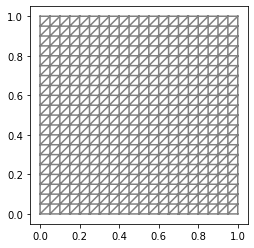

In [2]:
mesh_n = 20
mesh = UnitSquareMesh(mesh_n, mesh_n)
V = FunctionSpace(mesh, 'CG', 1)
plot(mesh)

$$-\int_\Omega v \nabla e^m \nabla u dx = \int_\Omega f v dx$$
$$\int_\Omega \nabla v \cdot e^m \nabla u dx + \int_{\partial \Omega}v n \cdot e^m\nabla u = \int_\Omega f v dx$$
$$au + n \cdot e^m \nabla u = b$$
$$u + n \cdot e^m \nabla u = 0$$
$$n \cdot e^m \nabla u = -u$$
$$\int_\Omega \nabla v \cdot e^m \nabla u dx - \int_{\partial \Omega}v u = \int_\Omega f v dx$$
$$g(m,u,v) = 0$$
$$f(x) = \sin\left(\omega \|x\|\right)$$

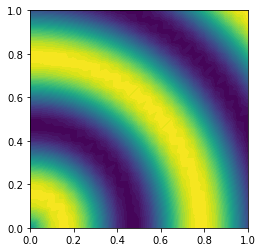

In [3]:
u = Function(V)
v = Function(V)
m = Function(V)

# f = Expression('sin(omega*sqrt(x[0]**2 + x[1]**2))', omega=3, degree=5)
f = Expression('sin(omega*sqrt(pow(x[0],2) + pow(x[1],2)))', omega=10, degree=5)
plot(f, mesh=mesh)

In [4]:
flux = exp(m) * grad(u)
nu = FacetNormal(mesh)

# g_form = (inner(flux, grad(v))*dx) + (v * inner(nu, flux) * ds) - (f * v * dx) # Bad BCs
g_form = (inner(flux, grad(v))*dx) + (v * u * ds) - (f * v * dx)

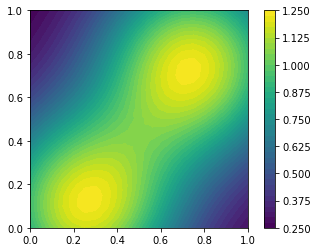

In [5]:
m_true1 = Expression('exp(- (pow(x[0]-a,2) + pow(x[1]-b,2))/s)', a=0.75, b=0.75, s=0.2, degree=5)
m_true2 = Expression('exp(- (pow(x[0]-a,2) + pow(x[1]-b,2))/s)', a=0.25, b=0.1, s=0.2, degree=5)
m_true = m_true1 + m_true2 + Constant(0.2)
cm = plot(m_true, mesh=mesh)
plt.colorbar(cm)

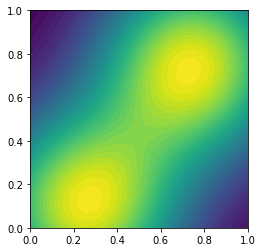

In [6]:
m.vector()[:] = project(m_true, V).vector()
plot(m)

In [7]:
u_trial = TrialFunction(V)
v_test = TestFunction(V)

print('u=', u)
print('v=', v)
print('m=', m)
print('flux=', flux)
print('f=', f)
print('u_trial=', u_trial)
print('v_test=', v_test)


print('g_form=', g_form)

g_form2 = replace(g_form, {u:u_trial, v:v_test})
print('g_form2=', g_form2)

g_lhs = lhs(g_form2)
g_rhs = rhs(g_form2)
print('g_lhs=', g_lhs)
print('g_rhs=', g_rhs)

G = assemble(g_lhs)
F = assemble(g_rhs)
print('G=', G)
print('F=', F)

u= f_5
v= f_8
m= f_11
flux= { A | A_{i_8} = (grad(f_5))[i_8] * exp(f_11) }
f= f_14
u_trial= v_1
v_test= v_0
g_form= { ({ A | A_{i_8} = (grad(f_5))[i_8] * exp(f_11) }) : (grad(f_8)) } * dx(<Mesh #0>[everywhere], {})
  +  { -1 * f_8 * f_14 } * dx(<Mesh #0>[everywhere], {})
  +  { f_5 * f_8 } * ds(<Mesh #0>[everywhere], {})
g_form2= { ({ A | A_{i_8} = (grad(v_1))[i_8] * exp(f_11) }) : (grad(v_0)) } * dx(<Mesh #0>[everywhere], {})
  +  { -1 * v_0 * f_14 } * dx(<Mesh #0>[everywhere], {})
  +  { v_0 * v_1 } * ds(<Mesh #0>[everywhere], {})
g_lhs= { sum_{i_9} ({ A | A_{i_8} = (grad(v_1))[i_8] * exp(f_11) })[i_9] * (conj(((grad(v_0))[i_9])))  } * dx(<Mesh #0>[everywhere], {})
  +  { v_0 * v_1 } * ds(<Mesh #0>[everywhere], {})
g_rhs= { -1 * -1 * v_0 * f_14 } * dx(<Mesh #0>[everywhere], {})
G= <dolfin.cpp.la.Matrix object at 0x7f796089bbd0>
F= <dolfin.cpp.la.Vector object at 0x7f7960b2b450>


FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), FiniteElement('Lagrange', triangle, 1))


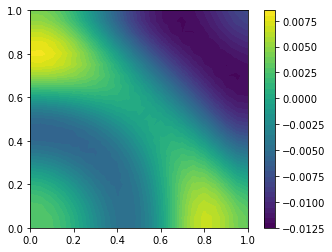

In [8]:
G_solver = LUSolver(G)
G_solver.solve(u.vector(), F)
cm = plot(u)
plt.colorbar(cm)
print(u.function_space()) # == V
print(u.vector()) # <-- petsc
# print(u.vector()[:]) # <-- numpy

$$J := \int_{\partial \Omega} u - u_\text{true} ds$$

In [9]:
u_true = Function(V)
u_true.vector()[:] = u.vector()[:].copy()

objective_form = pow(u - u_true, 2)*ds
print(assemble(objective_form))

u.vector()[:] = u.vector()[:] + 0.1*np.random.randn(V.dim())
print(assemble(objective_form))

0.0
0.02115941634516557


0.0001425373152989823


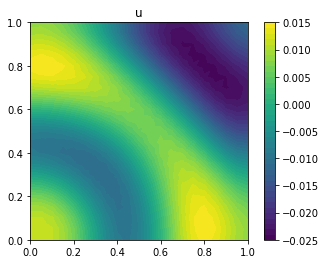

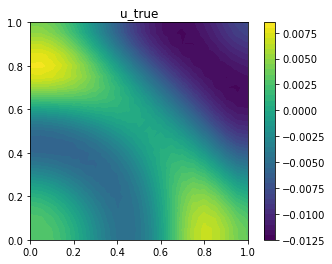

In [10]:
m.vector()[:] = 0.
G = assemble(g_lhs)
F = assemble(g_rhs)
G_solver = LUSolver(G)
G_solver.solve(u.vector(), F)

cm1 = plot(u)
plt.colorbar(cm1)
plt.title('u')

plt.figure()
cm2 = plot(u_true)
plt.colorbar(cm2)
plt.title('u_true')

print(assemble(objective_form))

$$\mathcal{L}(m,u,\lambda) := J(m,u,v) + \lambda^T g(m,u,\cdot)$$
$$\mathcal{L}(m,u,v) := J(m,u,v) + v^T g(m,u,\cdot)$$
$$\mathcal{L}(m,u,v) := J(m,u,v) + g(m,u,v)$$
$$a(m,u,v,\widetilde{u}) := \frac{\partial \mathcal{L}}{\partial u}(m,u,v,\widetilde{u}) = 0 \quad \text{for all }\widetilde{u}$$

{ sum_{i_{11}} ({ A | A_{i_8} = (grad(v_0))[i_8] * exp(f_11) })[i_{11}] * (conj(((grad(v_1))[i_{11}])))  } * dx(<Mesh #0>[everywhere], {})
  +  { (f_5 + -1 * f_66) * 2 * v_0 } * ds(<Mesh #0>[everywhere], {})
  +  { v_0 * v_1 } * ds(<Mesh #0>[everywhere], {})
A= <dolfin.cpp.la.Matrix object at 0x7f795c4384f0>
B= <dolfin.cpp.la.Vector object at 0x7f795c438720>


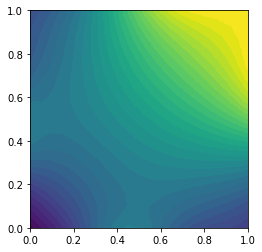

In [11]:
tilde_u = TestFunction(V)
v_trial = TrialFunction(V)

lagrangian_form = objective_form + g_form
adjoint_form = derivative(lagrangian_form, u, tilde_u)

adjoint_form2 = replace(adjoint_form, {v:v_trial})
print(adjoint_form2)

a_lhs = lhs(adjoint_form2)
a_rhs = rhs(adjoint_form2)

A = assemble(a_lhs)
B = assemble(a_rhs)
print('A=', A)
print('B=', B)

A_solver = LUSolver(A)
A_solver.solve(v.vector(), B)
plot(v)

objective0= 0.0001425373152989823


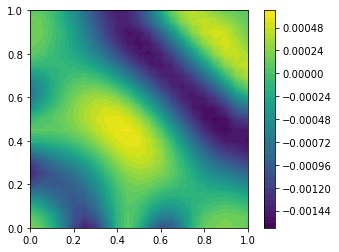

In [12]:
tilde_m = TestFunction(V)

gradient_form = derivative(lagrangian_form, m, tilde_m)
g_dual_vector = assemble(gradient_form)
print(g_dual_vector)

mass_form = u_trial * v_test * dx
M = assemble(mass_form)

M_solver = LUSolver(M)
p = Function(V)
M_solver.solve(p.vector(), g_dual_vector)

cm = plot(p)
plt.colorbar(cm)

objective0 = assemble(objective_form)
print('objective0=', objective0)

$$Hp = -g$$
$g \in X'$, $H:X \mapsto X'$, $p \in X$

$$m = m + \alpha p$$

$$m = m + \alpha g$$

$$Mp = -g$$

$M$ is mass matrix (or lumped mass matrix)

In [13]:
m_original_numpy_vector = m.vector()[:].copy()

s = 1e-6
dm = Function(V)
dm.vector()[:] = np.random.randn(V.dim())

m.vector()[:] = m_original_numpy_vector + s * dm.vector()[:]

# solve for u
G = assemble(g_lhs)
F = assemble(g_rhs)
G_solver = LUSolver(G)
G_solver.solve(u.vector(), F)

# solve for adjoint v
A = assemble(a_lhs)
B = assemble(a_rhs)

A_solver = LUSolver(A)
A_solver.solve(v.vector(), B)

objective2 = assemble(objective_form)
print('objective2=', objective2)

dJ_diff = (objective2 - objective0)/s
print('dJ_diff=', dJ_diff)

dJ = np.dot(g_dual_vector[:], dm.vector()[:])
print('dJ=', dJ)

err_grad = (dJ - dJ_diff)/dJ_diff
print('err_grad=', err_grad)

objective2= 0.00014253732778571728
dJ_diff= 1.2486734980417594e-05
dJ= 1.2486784517856645e-05
err_grad= 3.967205128417246e-06


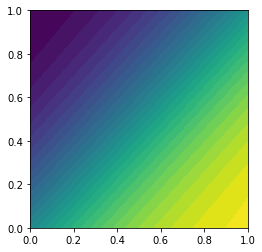

In [14]:
asdf = Function(V)
asdf.vector()[:] = np.arange(V.dim()) # [0,1,2,3,...]
plot(asdf)